<a href="https://colab.research.google.com/github/luiscascelli/IGTI_machine_learning/blob/master/Desafio_4(A).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l06c03_exercise_flowers_with_transfer_learning_solution.ipynb

In [ ]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [ ]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [ ]:
#Baixar e dividir o dataset

(training_set, validation_set), dataset_info = tfds.load('tf_flowers',
                                                          split=['train[:70%]', 'train[70%:]'],
                                                          with_info=True,
                                                          as_supervised=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.


In [ ]:
#Informações sobre o dataset

num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



In [ ]:
#Verificando o tamanho das imagens
#Imagens não tem o mesmo tamanho, devemos formatar

for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


In [ ]:
#Formata as imagens para o tamanho esperado para a rede pré treinada MobileNet V2 (224,224) e normaliza
#Cria batches de 32

IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [ ]:
#Cria o extrator de caracteristicas a partir da rede pré treinada MobileNet V2, usando o TensorFlow Hub

URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))

In [ ]:
#Congela as camadas da rede para não atualizar os pesos

feature_extractor.trainable = False

In [ ]:
#Cria um modelo de rede sequencial com a rede pré treinada e adiciona uma ultima camada Dense que será treinada para a classificação

model = tf.keras.Sequential([feature_extractor,layers.Dense(num_classes)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
#Compila o modelo com os parâmetros desejados

model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [ ]:
#Treina o modelo

EPOCHS = 6

history = model.fit(train_batches, epochs=EPOCHS, validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 125s 2s/step - loss: 0.7511 - accuracy: 0.7236 - val_loss: 0.4302 - val_accuracy: 0.8574
Epoch 2/6
81/81 [==============================] - 126s 2s/step - loss: 0.3793 - accuracy: 0.8704 - val_loss: 0.3436 - val_accuracy: 0.8856
Epoch 3/6
81/81 [==============================] - 127s 2s/step - loss: 0.2993 - accuracy: 0.8972 - val_loss: 0.3054 - val_accuracy: 0.9001
Epoch 4/6
81/81 [==============================] - 129s 2s/step - loss: 0.2458 - accuracy: 0.9241 - val_loss: 0.2965 - val_accuracy: 0.9001
Epoch 5/6
81/81 [==============================] - 129s 2s/step - loss: 0.2118 - accuracy: 0.9373 - val_loss: 0.2916 - val_accuracy: 0.9019
Epoch 6/6
81/81 [==============================] - 127s 2s/step - loss: 0.1868 - accuracy: 0.9494 - val_loss: 0.2841 - val_accuracy: 0.9001


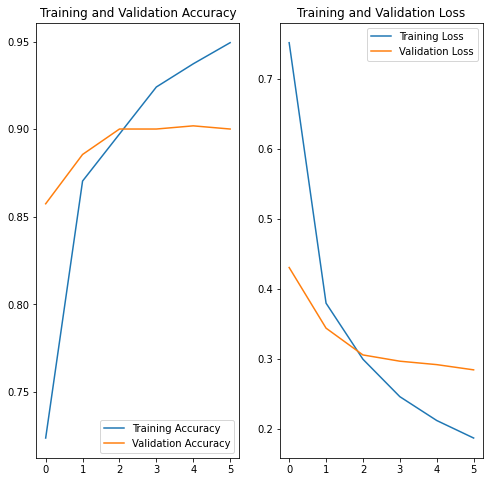

In [ ]:
#Gráficos do treinamento e validação

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#Nomes das classes

class_names = np.array(dataset_info.features['label'].names)

print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


In [ ]:
#In the cell below, use the next() function to create an image_batch and its corresponding label_batch. 
#Convert both the image_batch and label_batch to numpy arrays using the .numpy() method.
#Then use the .predict() method to run the image batch through your model and make predictions. 
#Then use the np.argmax() function to get the indices of the best prediction for each image. 
#Finally convert the indices of the best predictions to class names.

image_batch, label_batch = next(iter(train_batches))


image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

['roses' 'roses' 'sunflowers' 'sunflowers' 'tulips' 'daisy' 'dandelion'
 'sunflowers' 'tulips' 'dandelion' 'sunflowers' 'sunflowers' 'roses'
 'dandelion' 'sunflowers' 'roses' 'sunflowers' 'daisy' 'daisy' 'tulips'
 'dandelion' 'sunflowers' 'sunflowers' 'roses' 'roses' 'dandelion' 'roses'
 'tulips' 'daisy' 'dandelion' 'sunflowers' 'tulips']


In [ ]:
#Classes verdadeiras e classes previstas

print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [4 4 3 3 2 1 0 3 2 0 3 3 4 0 3 4 3 1 1 2 0 3 3 4 4 0 3 2 1 0 3 2]
Predicted labels:  [4 4 3 3 2 1 0 3 2 0 3 3 4 0 3 4 3 1 1 2 0 3 3 4 4 0 4 2 1 0 3 2]


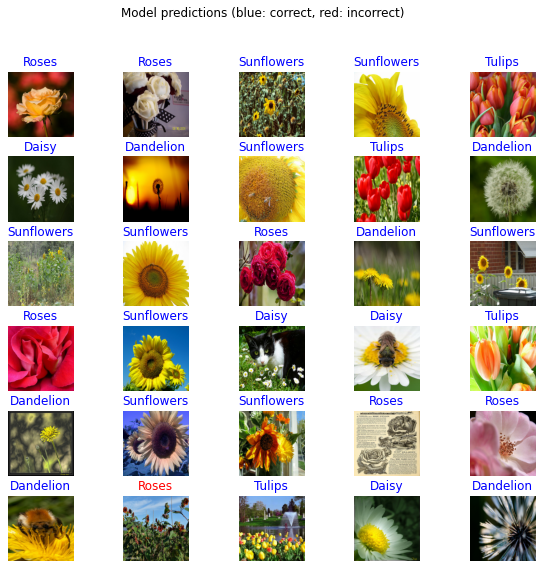

In [ ]:
#PLotar as previsões

plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")